# Linear Regression 

Four main component in this notebook:
- Implementation of the iterative optimization Gradient Descent algorithms for solving a Linear Regression problem
- Implementation of various regularization techniques
- Polynomial regression
- Learning curve

### Dataset

**Red wine** quality dataset URL: https://archive.ics.uci.edu/ml/datasets/wine+quality

The dataset is related to the **Red** variants of the Portuguese "Vinho Verde" wine. It provides the physicochemical (inputs) and sensory (the output) variables are available.

The dataset consists of characteristics of white wine (e.g., alcohol content, density, amount of citric acid, pH, etc) with target variable "quality" representing rating of wine.

Given the characteristics of a new, unlabeled wine, the regression task is to predict its "quality".

Input variables (based on physicochemical tests):
- fixed acidity
- volatile acidity
- citric acid
- residual sugar
- chlorides
- free sulfur dioxide
- total sulfur dioxide
- density
- pH
- sulphates
- alcohol

Output variable (based on sensory data): 
- quality 

In [7]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.preprocessing import StandardScaler
# from sklearn.model_selection import train_test_split, learning_curve, GridSearchCV, cross_val_score
# from sklearn.linear_model import Ridge, Lasso, ElasticNet, SGDRegressor
# from sklearn.metrics import mean_squared_error, r2_score
from sklearn import linear_model
from sklearn import preprocessing
# from sklearn.pipeline import make_pipeline
import itertools
import warnings
warnings.filterwarnings('ignore')

# Part A: Model Code

### 1. Function that generates the polynomial and interaction features for a given degree of the polynomial.

In [162]:
def polynomialFeatures(X, degree):
    '''
    Arguments:

    X : ndarray 
        A numpy array with rows representing data samples and columns representing features (d-dimensional feature).

    degree : integer
        The degree of the polynomial features. Default = 1.

    Returns:

        A new feature matrix consisting of all polynomial combinations of the features with degree equal to the specified degree. 
        For example, if an input sample is two dimensional and of the form [a, b], 
        the degree-2 polynomial features are [a, b, a2, ab, b2].
    '''
    map_terms = {}
    poly_term = []
    result_term = []
    for i in range(X.shape[1]):
        map_terms[i] = X[:,i]
        poly_term.append(i)

    terms = get_polynomial(poly_term, degree)
    result = 1
    for sublst in terms:
        for x in sublst:
            if x == 'cons':
                result *= np.ones((X.shape[0],), dtype=int)
            else:
                result *= map_terms[x] 
                
        result_term.append(result)
        result = 1
    
    return np.array(result_term).T

def get_polynomial(vars, degree):

    vars.append("cons") # add dummy variable
    
    # compute all combinations of variables
    terms = []
    for x in itertools.combinations_with_replacement(vars, degree):
        terms.append(x)

    # get rid of "c" terms
    terms = map(list, terms)
    terms = list(terms)
 
    return terms

### Sanity check

In [163]:
#sanity check
X = np.array([
    [2,3,4],
    [1,2,2]
])
y = np.array([0,3])

print('''
Example of get_polynomial() function.
This will return combinatoric of n between 2 variables''')
display(get_polynomial(['x1', 'x2', 'x3'], 3))
print("polynomial features")
print(polynomialFeatures(X, 2))

print('''
\n__________Expected from Sklearn________
Note: here our result does math with sklearn, 
order are mixed. but SGD keep order consistence
when training.
''')
poly = preprocessing.PolynomialFeatures(2)
poly.fit_transform(X)


Example of get_polynomial() function.
This will return combinatoric of n between 2 variables


[['x1', 'x1', 'x1'],
 ['x1', 'x1', 'x2'],
 ['x1', 'x1', 'x3'],
 ['x1', 'x1', 'cons'],
 ['x1', 'x2', 'x2'],
 ['x1', 'x2', 'x3'],
 ['x1', 'x2', 'cons'],
 ['x1', 'x3', 'x3'],
 ['x1', 'x3', 'cons'],
 ['x1', 'cons', 'cons'],
 ['x2', 'x2', 'x2'],
 ['x2', 'x2', 'x3'],
 ['x2', 'x2', 'cons'],
 ['x2', 'x3', 'x3'],
 ['x2', 'x3', 'cons'],
 ['x2', 'cons', 'cons'],
 ['x3', 'x3', 'x3'],
 ['x3', 'x3', 'cons'],
 ['x3', 'cons', 'cons'],
 ['cons', 'cons', 'cons']]

polynomial features
[[ 4  6  8  2  9 12  3 16  4  1]
 [ 1  2  2  1  4  4  2  4  2  1]]


__________Expected from Sklearn________
Note: here our result does math with sklearn, 
order are mixed. but SGD keep order consistence
when training.



array([[ 1.,  2.,  3.,  4.,  4.,  6.,  8.,  9., 12., 16.],
       [ 1.,  1.,  2.,  2.,  1.,  2.,  2.,  4.,  4.,  4.]])

### 2. Mean Square Error of Two Vectors

$$
MSE = {\sum(y - \hat{y})^2}
$$

In [164]:
mse = lambda y_true, y_pred : np.mean((y_true-y_pred)**2)

In [165]:
#extra
def r2_score(y, y_hat):
    SS_total = ((y - y.mean())**2).sum()
    SS_res = ((y - y_hat)**2).sum()
    return 1 - (SS_res/SS_total)

### Sanity check

In [166]:
#sanity check
y_true = np.random.randint(10, size=(4,))
y_pred = np.random.randint(10, size=(4,))
print('y_true:', y_true)
print('y_pred:', y_pred)
print('implemented', mse(y_true, y_pred))

from sklearn import metrics
print('expected from sklearn', metrics.mean_squared_error(y_true, y_pred))

y_true: [2 3 8 2]
y_pred: [7 1 4 9]
implemented 23.5
expected from sklearn 23.5


### 5. Linear Regression Model Class 
Optimization algorithm - batch gradient descent algorithm

In [167]:
class Linear_Regression(object):
    def __init__(self):
        self.params = {} #save model weights
        
    def predict(self, X):
        #(N,1) = (N,D) dot (D,1)
        return X.dot(self.params['w']).reshape(-1) #(N,D) dot (D,1) = (N,1)
    
    def loss(self, X, y):
        '''
        Inputs:
        - X: np array of shape (N,D)
        - y: np  array of shape (N,1)
        '''
        N, D = self.X.shape
        #forward pass
        #(N,1) = (N,D) dot (D, 1)
        scores = X.dot(self.params['w'])
        
        #backward pass
        loss, dw = 0.0, None
        loss = (0.5/N) * np.sum((y-scores)**2)
        #get mse loss and dout here
        #(N,1) = (N,1) - (N,1)
        dout = (1./N) * (scores - y)
        
        
        #y = wx + b -> dy/db = dout/dy * dy/db = dout * 1.0
        
        #dout/dw = dout/dy dot dy/dw = dout dot x
        #(D,1) = (D,N) dot (N, 1)
        dw = X.T.dot(dout)
        #add regulirizer strength
        if self.regularizer is 'l2':
            loss += (self.lambd/N)*np.sum(self.params['w']**2)
            dw += (self.lambd/N)*self.params['w']
        elif self.regularizer is 'l1':
            loss += (self.lambd/N)*np.sum(self.params['w'])
            dw += (self.lambd/N)*(1/2) * (self.params['w']/np.abs(self.params['w'])) 
            
        #perform clip grad to avoid grad explosion
        dw = np.clip(dw, a_min=-1.0, a_max=1.0)
        return loss, dw
    
    def fit(self, X, Y, learning_rate=1e-1, 
                   epochs=300, tol=None, regularizer=None,
                   lambd=0.0001, verbose=False, lr_decay=0.95,
                   batch_size=None):
        '''
        Inputs:
        - X: numpy array of inputs vector  (N, D)
        - Y: numpy array of target vector (N,1)
        - learning_rate: float provide the step size
        - epochs: int provide number of passes through in dataset
        - tol: float or None provide the stopping criterion.
         iteration will stop when (loss > previous_loss - tol) 
        - batch_size: python integer indicate number of input feature per batch
         None indicate to use all input feature to train in one batch
         default to None
        - regularizer: string of 'l1' or 'l2'
        - lambd: float provide regularize coeff
        '''
        loss_hist = []
        self.X = X
        self.y = Y
        self.learning_rate = learning_rate
        self.regularizer = regularizer
        self.tol = tol
        self.lambd = lambd
        self.lr_decay = lr_decay
        
        self.epochs = epochs
        
        N, D = self.X.shape
        
        self.params['w'] = np.random.randn(D,1)
        prev_loss = 0.0
        for e in range(self.epochs):
            
            #if no batch gradient descent
            X_batch = self.X
            y_batch = self.y
            
            #if batch gradient descent
            if batch_size: 
                sampling_idxs = np.random.choice(np.arange(N), batch_size, replace=False)#False: mean no repeated
                X_batch = self.X[sampling_idxs] 
                y_batch = self.y[sampling_idxs]
            
            loss, dw = self.loss(X_batch, y_batch)
            
            #SGD
            self.params['w'] -= self.learning_rate * dw
            
            if e % 20 == 0 : 
                self.learning_rate *= self.lr_decay
                if verbose: print('epoch', e, 'loss', loss)
            loss_hist.append(loss)#track the loss
            
            #early stopping
#             if self.tol: 
#                 if loss > (prev_loss - self.tol):
#                     break
            prev_loss = loss
        return loss_hist

### Sanity check

Learning weight
 {'w': array([[-1.32605977],
       [ 9.60824876]])}

skearn model weight
 [-0.57273843  9.2574323 ]
(100, 2)

___NOTE___:
our implemented model line on top with Sklearn model



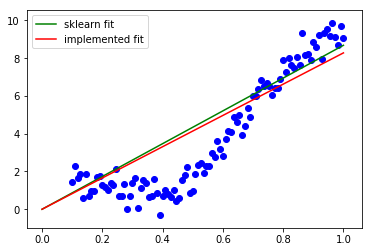

In [168]:
#sanity check

#generate synthetic data
data_x = np.linspace(1.0, 10.0, 100)[:, np.newaxis]
data_y = np.sin(data_x) + 0.1*np.power(data_x,2) + 0.5*np.random.randn(100,1 )
data_x /= np.max(data_x)
data_x = np.hstack((np.ones_like(data_x), data_x))

LR = Linear_Regression()

loss_hist = LR.fit(data_x, data_y, 
                   epochs=15000, 
                   regularizer='l1',
                   learning_rate=1e-1, 
                   verbose=False,
                   batch_size=100)

LR_sklearn = linear_model.SGDRegressor(loss='squared_loss',
                                       penalty=None,tol=None, 
                                       alpha=0.1, max_iter=300)
LR_sklearn.fit(data_x, data_y)

print("Learning weight\n", LR.params)
print("\nskearn model weight\n", LR_sklearn.coef_)

print(data_x.shape)
sp = np.linspace(0, 1.0, 100)
gen_sk = sp* LR_sklearn.coef_[0] + sp * LR_sklearn.coef_[1]
gen = sp * LR.params['w'][0] + sp * LR.params['w'][1]
plt.plot(sp, gen_sk, color='green', label="sklearn fit")
plt.plot(sp, gen, color='red', label='implemented fit')
plt.scatter(data_x[:,1], data_y, c='b')
plt.legend()

print('''
___NOTE___:
our implemented model line on top with Sklearn model
''')

### Check with sklearn

In [170]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

#crane_path = r'/work/cseos2g/datduyn/Documents/datasets/wine-quality/winequality-red.csv'
#window_path = r'C:\Users\datng\Documents\datasets\wine-quality\winequality-red.csv'
#crane_path = r'/home/cse496dl/otiong/machineLearning/assignment_1/winequality-red.csv'
window_path = r'C:\Users\onsai\CSCE478\datasets\DataScienceRepository\winequality-red.csv'

df = pd.read_csv(window_path,delimiter=';')

# df = df.drop(columns=['total sulfur dioxide'])

df.head()
X = df.drop(columns=['quality']) 
y = df['quality']


X_train_red, X_test_red, y_train_red, y_test_red = train_test_split(X, y, 
                                        test_size=0.2, 
                                        random_state=42)

lin_reg_sgd = linear_model.SGDRegressor(max_iter=1000, 
                           learning_rate="constant", 
                           eta0=0.00001, l1_ratio=0.2,
                           alpha=0.01)


# Train the model
lin_reg_sgd.fit(X_train_red, y_train_red)
# Make prediction 
y_test_predicted_sgd = lin_reg_sgd.predict(X_test_red)


print("sk learn Mean squared error: %.2f"
      % mean_squared_error(y_test_red, y_test_predicted_sgd), 
     'r^2 val:', r2_score(y_test_red, y_test_predicted_sgd))

LR = Linear_Regression()
loss = LR.fit(np.array(X_train_red), np.array(y_train_red[:,None]), 
      learning_rate=0.0035, 
      epochs=2000, tol=None, 
      regularizer=None,
      lambd=0)

y_test_predicted = LR.predict(np.array(X_test_red))

print("Implemented Mean squared error: %.2f"
      % mean_squared_error(y_test_red, y_test_predicted.ravel()), 
     'r^2 val:', r2_score(y_test_red, y_test_predicted))

sk learn Mean squared error: 0.48 r^2 val: 0.2673913597909412
Implemented Mean squared error: 0.94 r^2 val: -0.4437004829096196


### 3. Learning Curves

In [171]:
def learning_curve(model, X_input, Y_target, cv, train_size=np.linspace(0.1, 1.0, 10), learning_rate=0.01, epochs=1000, tol=None, regularizer=None, lambd=0.0, **kwargs):
    '''
    Arguments: 
    - model: object type that implements the “fit” and “predict” methods. An object of that type which is cloned for each validation.
    - X_input: ndarray A numpy array with rows representing data samples and columns representing features.
    - Y_target: ndarray A 1D numpy array with labels corresponding to each row of the feature matrix X.
    - cv : int integer, to specify the number of folds in a k-fold cross-validation.
    - train_sizes : intor float Relative or absolute numbers of training examples that will be used to generate the learning curve. 
        If the dtype is float, it is regarded as a fraction of the maximum size of the training set 
        (that is determined by the selected validation method), i.e. it has to be within (0, 1]. 
        Otherwise it is interpreted as absolute sizes of the training sets. 
    - epochs :int The maximum number of passes over the training data for updating the weight vector.
    -tol : float or None The stopping criterion. If it is not None, the iterations will stop when (error> previous_error-tol). 
         If it is None, the number of iterations will be set by the “epochs”.
    - regularizer: string The string value could be one of the following: l1, l2, None. 
        If it’s set to None, the cost function without the regularization term will be used for computing the gradient 
        and updating the weight vector. However, if it’s set to l1 or l2, the appropriate regularized cost function needs to be used 
        for computing the gradient and updating the weight vector.
    - lambd: floatIt provides the regularization coefficient. It is used only when the “regularizer” is set to l1 or l2.
    Returns:
    - train_scores : ndarray root-mean-square error(rmse) values on training sets.
    - val_scores : ndarray root-mean-square error(rmse) values on validation sets.    
    '''
    #edge case: value of cv must be more than sample size/ cannot be 1
    
    N, D = X_input.shape
    train_scores = []
    val_scores = []
    for step in train_size:
        cur_X = X_input[0:int(step*N)]
        cur_Y = Y_target[0:int(step*N)]
        x_train_folds = np.array(np.array_split(cur_X, cv))
        y_train_folds = np.array(np.array_split(cur_Y, cv))
        
        
        train_score = 0
        val_score = 0
        for idx, val_fold in enumerate(x_train_folds):
            train_folds = tuple([f for i, f in enumerate(x_train_folds) if(i != idx)])
            label_folds = tuple([f[:,None] for i, f in enumerate(y_train_folds) if(i != idx)])
            
            #get to the right shape
            train_inp = np.vstack(train_folds)
            target_inp = np.vstack(label_folds)
            
            # Train the model
            model.fit(train_inp,target_inp)

            train_pred = model.predict(train_inp)
            val_pred = model.predict(val_fold)
            train_score += mse(target_inp.reshape(-1), 
                               train_pred.reshape(-1))
            val_score += mse(y_train_folds[idx].reshape(-1), 
                             val_pred.reshape(-1))
            
        train_scores.append(train_score/cv)
        val_scores.append(val_score/cv)
    
    return np.sqrt(train_scores), np.sqrt(val_scores)

### Sanity check

[0.55465753 0.51177812 0.5029361  0.52126455 0.58566278 0.85980294
 1.16448057 1.35329871 1.40645984 1.45180017] [0.67943218 0.61215809 0.63171627 0.62336688 0.6267763  1.27530902
 1.67970859 2.03986873 2.1909318  2.04355012]


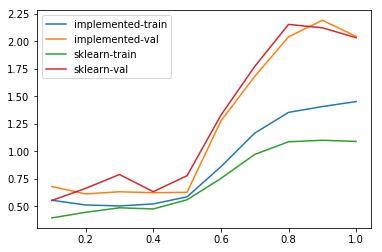


________Result discussion________
Here result is as expected. Observing the implemented-train and sklearn-train 
are diminishing in at the same rate and in the same direction. 
Since Sklearn LinearRegression.fit is implemented using OLS this result
in an optimal solution. Our implementation is Gradient optimizing base
therefore, our MSE score is higher.



In [172]:
#Sanity check
data_x = np.linspace(1.0, 10.0, 100)[:, np.newaxis]
data_y = np.sin(data_x) + 0.1*np.power(data_x,2) + 0.5*np.random.randn(100,1 )
data_x /= np.max(data_x)
data_x = np.hstack((np.ones_like(data_x), data_x))


a, b =learning_curve(Linear_Regression(), data_x, data_y[:,0], 5, 
                     learning_rate=0.01, epochs=4000, tol=None, regularizer=None, lambd=0.0)
print(a, b)

plt.plot(np.linspace(0.1, 1.0, 10),a, label='implemented-train')
plt.plot(np.linspace(0.1, 1.0, 10),b, label='implemented-val')


a, b = learning_curve(linear_model.LinearRegression(), data_x, data_y[:,0], 5, 
                      learning_rate=0.01, epochs=1000, tol=None, regularizer=None, lambd=0.0)
plt.plot(np.linspace(0.1, 1.0, 10),a, label='sklearn-train')
plt.plot(np.linspace(0.1, 1.0, 10),b, label='sklearn-val')
plt.legend()
plt.show()

print('''
________Result discussion________
Here result is as expected. Observing the implemented-train and sklearn-train 
are diminishing in at the same rate and in the same direction. 
Since Sklearn LinearRegression.fit is implemented using OLS this result
in an optimal solution. Our implementation is Gradient optimizing base
therefore, our MSE score is higher.
''')

### 4. Polynomial Model Complexity Plotting

In [22]:
def plot_polynomial_model_complexity(model, X, Y, cv, 
                                     maxPolynomialDegree, 
                                     learning_rate=0.01, 
                                     epochs=1000, tol=None, 
                                     regularizer=None, lambd=0.0):
    '''
    Arguments:
        model : object type that implements the “fit” and “predict” methods. An object of that type which is 
        cloned for each validation.
        
        X: ndarray A numpy array with rows representing data samples and columns representing features.
        
        Y: ndarplot_polynomial_model_complexity(LinearRegression(), X_train, y_train, 5, 5, learning_rate=0.01,
        epochs=1000, tol=None, regularizer=None, lambd=0.0)ray A 1D numpy array with labels corresponding to 
        each row of the feature matrix X.
        
        cv : int integer, to specify the number of folds in a (Stratified) K-Fold,
        
        maxPolynomialDegree: int It will be used to determine the maximum polynomial degree for X. 
            For example, if it is set to 3, then the function will compute both the training and 
            validation mse values for degree 1, 2 and 3.
            
        learning_rate: float It provides the step size for parameter update.
        
        epochs: int The maximum number of passes over the training data for updating the weight vector.
        
        tol: float or None The stopping criterion. If it is not None, the iterations will stop when (error> 
        previous_error-tol).If it is None, the number of iterations will be set by the “epochs”.
            
        regularizer: string The string value could be one of the following: l1, l2, None. 
            If it’s set to None, the cost function without the regularization term will be used for computing 
            the gradientand updating the weight vector. However, if it’s set to l1 or l2, the appropriate 
            regularized cost function needs to be used for computing the gradient and updating the weight vector.
            
        lambd: float It provides theregularization coefficient.It is used only when the “regularizer” is set to l1 or l2.
        
    Returns:
        There is no return value. This function plots the root-mean-square error (rmse) values for both the training set 
        and the validation set for degree of X between 1 and maxPolynomialDegree.
    '''
    degree_list = []
    train_scores = []
    val_scores = []
    for i in range(1, maxPolynomialDegree + 1):
        degree_list.append(i)
        X_poly = polynomialFeatures(X, i)
    
        x_train_folds = np.array(np.array_split(X_poly, cv))
        y_train_folds = np.array(np.array_split(Y, cv))

        train_score = 0
        val_score = 0
        for idx, val_fold in enumerate(x_train_folds):
            train_folds = tuple([f for i, f in enumerate(x_train_folds) if(i != idx)])
            label_folds = tuple([f[:,None] for i, f in enumerate(y_train_folds) if(i != idx)])

            #get to the right shape
            train_inp = np.vstack(train_folds)
            target_inp = np.vstack(label_folds)
            model.fit(train_inp,target_inp, learning_rate=learning_rate, epochs=epochs,
                             regularizer=regularizer, lambd=lambd, tol=tol)

            train_pred = model.predict(train_inp)
            val_pred = model.predict(val_fold)
    
            train_score += mse(target_inp.reshape(-1), 
                               train_pred.reshape(-1))
            val_score += mse(y_train_folds[idx].reshape(-1), 
                             val_pred.reshape(-1))
            
        train_scores.append(train_score/cv)
        val_scores.append(val_score/cv)
        
    plt.figure(figsize=(10, 6))   
    plt.plot(degree_list, np.sqrt(val_scores), "ro-", 
             alpha=1.0, linewidth=1.0, label="Validation RMSE")
    plt.plot(degree_list, np.sqrt(train_scores), "bo-", 
             alpha=1.0, linewidth=1.0, label="Train RMSE")    
    plt.legend(loc="best", fontsize=14) 
    plt.xlabel("Degree")
    plt.ylabel("RMSE")
    plt.title("RMSE for Varying Degree")
    plt.show()
    return train_scores, val_scores

### Plot with random data

_____________Implemented___________


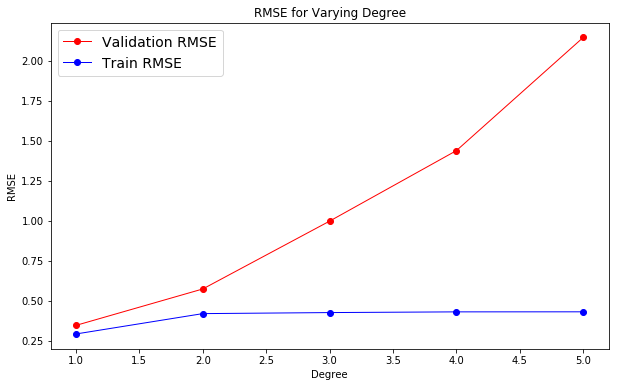

In [24]:
X_train_ = np.random.rand(100,10)
y_train_ = np.random.rand(100)

print("_____________Implemented___________")
_, _ = plot_polynomial_model_complexity(Linear_Regression(), X_train_, y_train_, 5, 5, 
                                 learning_rate=0.1, epochs=7000, tol=None, 
                                 regularizer=None, lambd=0.0)


# LR_sklearn = linear_model.SGDRegressor(loss='squared_loss',
#                                        penalty=None,tol=None, 
#                                        alpha=1e-1, max_iter=1000)


# print('\n______________Sklearn_______________')
# _, _ = plot_polynomial_model_complexity(LR_sklearn, X_train_, y_train_, 5, 5, 
#                                  learning_rate=0.0001, epochs=1000, tol=None, 
#                                  regularizer=None, lambd=0.0)

### Sanity Check

In [25]:
#this sanity check tell how frequently does our metrics got off base on sklearn
def syn_prob(time=100):
    implement_win = 0
    sklearn_win = 0
    avg_diff = 0.0
    for t in range(time):
        X_train_ = np.random.rand(1000,2)
        y_train_ = np.random.rand(1000,1)

        X_val_ = np.random.rand(5,2)
        y_val_ = np.random.rand(5,1)

        LR = Linear_Regression()

        # mean_dim = np.mean(X_train_, axis=0)
        # std_dim = np.std(X_train_, axis=0)

        # X_train_ = (X_train_ - mean_dim)/std_dim

        loss_hist = LR.fit(X_train_, y_train_, learning_rate=1e-1, 
                           epochs=1000, regularizer='l2',
                           lambd=0.0001)
        pred_implemented = LR.predict(X_val_)

        LR_sklearn = linear_model.SGDRegressor(loss='squared_loss',
                                               penalty='l2',tol=1e-2, 
                                               alpha=1e-1, max_iter=100)
        _ = LR_sklearn.fit(X_train_, y_train_)
        pred_sk = LR_sklearn.predict(X_val_)

        iml = mse(pred_implemented.ravel(), y_val_.ravel())
        skl = mse(pred_sk.ravel(), y_val_.ravel())
        if iml < skl: 
            implement_win+=1 
        else: 
            sklearn_win+=1 
            avg_diff += abs(abs(iml) - abs(skl) )/ abs(iml)*100
            
    print("Implemented win", implement_win/time,'%oftimes', ' with avg_diff', avg_diff/sklearn_win, '%')
    print("Sklearn win", sklearn_win/time)

syn_prob(time=100)

Implemented win 0.21 %oftimes  with avg_diff 35.89660748722701 %
Sklearn win 0.79


# Part B: Data Processing

### 6. Read in white wine portion of the wine quality dataset from UCI's repository

In [59]:
#crane_path = r'/work/cseos2g/datduyn/Documents/datasets/wine-quality/winequality-red.csv'
# window_path = r'C:\Users\datng\Documents\datasets\wine-quality\winequality-red.csv'
#crane_path = r'/home/cse496dl/otiong/machineLearning/assignment_1/winequality-red.csv'
window_path = r'C:\Users\onsai\CSCE478\datasets\DataScienceRepository\winequality-red.csv'

df = pd.read_csv(window_path,delimiter=';')
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


### 7. Explore and summarize dataset

In [60]:
df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


In [48]:
df.shape

(1599, 12)

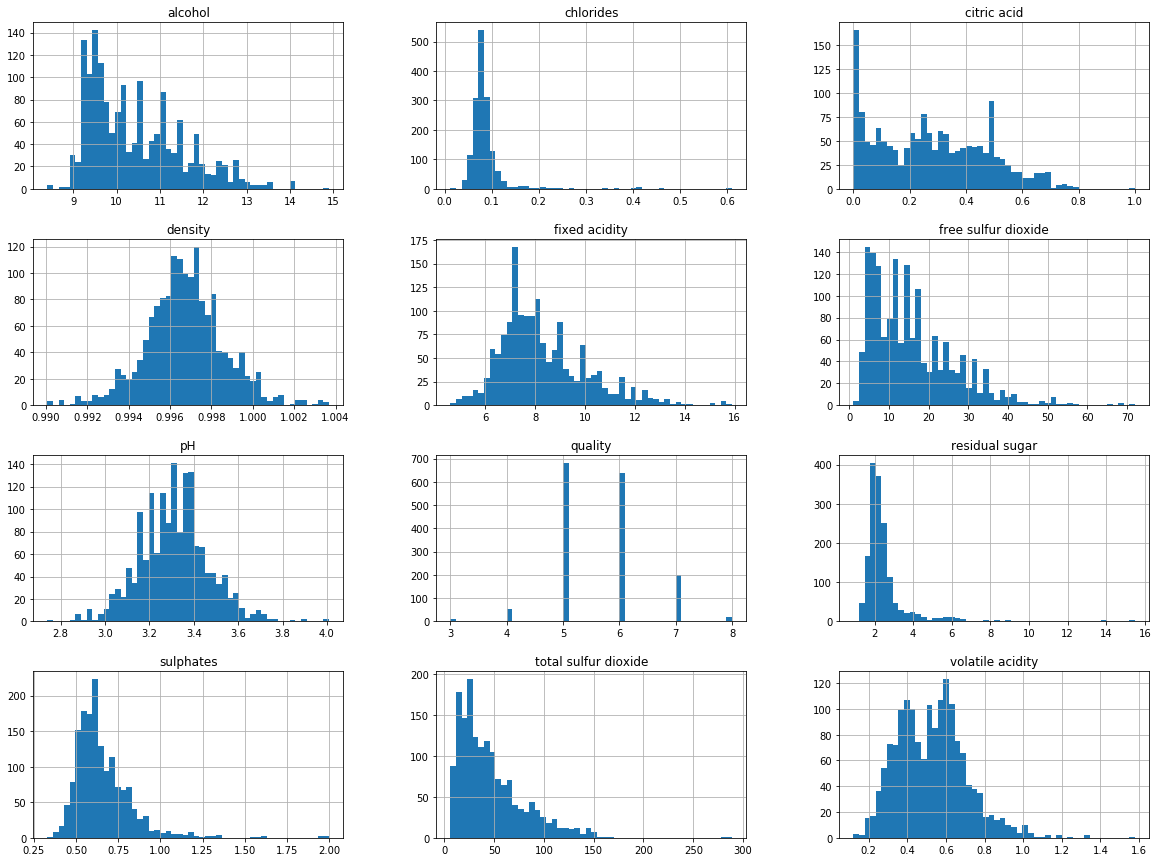

In [61]:
_ = df.hist(bins=50, figsize=(20,15))

### 8. Shuffle the data
- Use `def = df.sample(frac=1) ` 

In [62]:
df = df.sample(frac=1)
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
51,6.6,0.52,0.04,2.2,0.069,8.0,15.0,0.99560,3.40,0.63,9.4,6
15,8.9,0.62,0.19,3.9,0.170,51.0,148.0,0.99860,3.17,0.93,9.2,5
106,7.8,0.41,0.68,1.7,0.467,18.0,69.0,0.99730,3.08,1.31,9.3,5
824,7.1,0.48,0.28,2.8,0.068,6.0,16.0,0.99682,3.24,0.53,10.3,5
659,7.1,0.84,0.02,4.4,0.096,5.0,13.0,0.99700,3.41,0.57,11.0,4


### 9. Generate pair plot

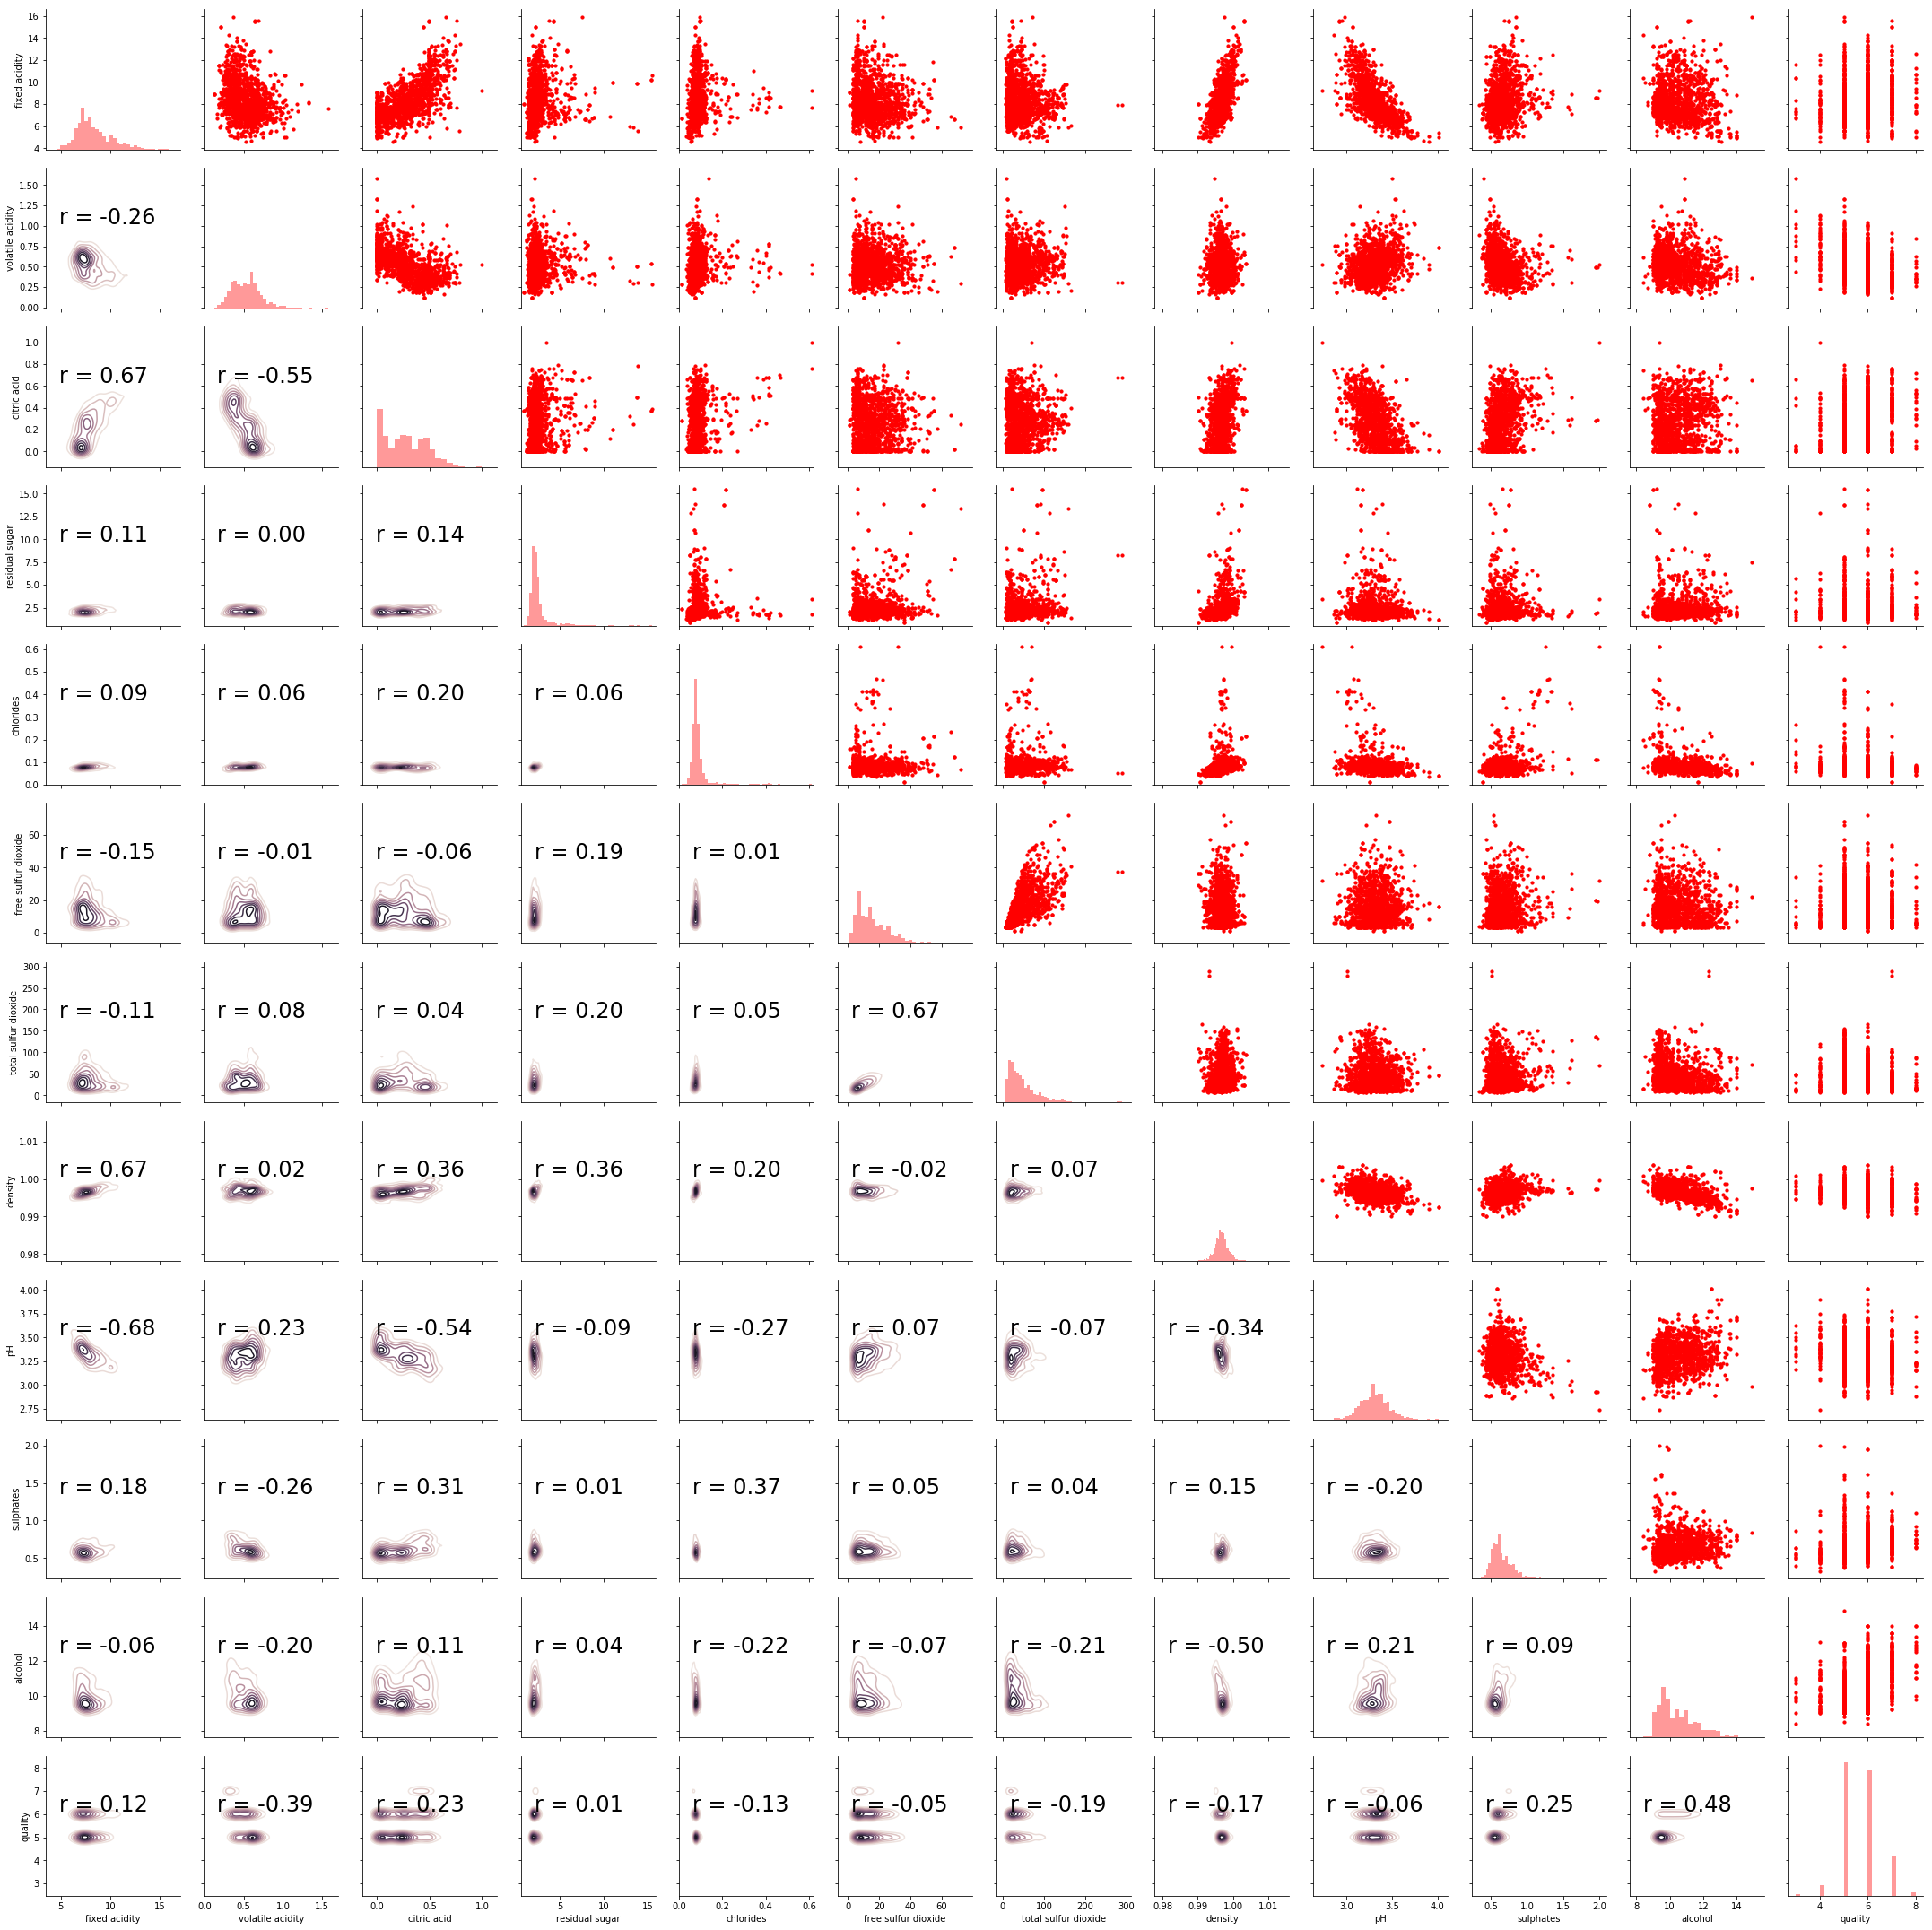

In [31]:
import seaborn as sns
from scipy import stats

# Calculate correlation coefficient
def corrfunc(x, y, **kws):
    r, _ = stats.pearsonr(x, y)
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.1, .6), xycoords=ax.transAxes,
               size = 24)
    
cmap = sns.cubehelix_palette(light=1, dark = 0.1,
                             hue = 0.5, as_cmap=True)

sns.set_context(font_scale=2)

# Pair grid set up
g = sns.PairGrid(df)

# Scatter plot on the upper triangle
g.map_upper(plt.scatter, s=10, color = 'red')

# Distribution on the diagonal
g.map_diag(sns.distplot, kde=False, color = 'red')

# Density Plot and Correlation coefficients on the lower triangle
g.map_lower(sns.kdeplot, cmap = cmap)
g.map_lower(corrfunc);

In [174]:
df = df.drop(columns=['fixed acidity','residual sugar'], axis=1)

### 10. Function to split to train and test set

In [64]:
def split_train_test(X, y, 
                     partition_percent=[.8,.2], shuffle=False):
    '''
    Partioning the data:
    args:
        - X: train set numpy or dataframe with shape(N,D)
        - y: labels numpy or dataframe with shape(N,)
        - partition_percent: python list of data percentage
         to partition. ex: [.8, .2] -> part of data
         will be split to .8 and part will be .2.
         NOTE: have to sum up to 1.0
        - shuffle: shuffle before partitioning or not?
    '''
    
    #convert from panda series to numpy
    try:
        X = X.as_matrix()
        y = y.as_matrix()
    except: #incase given X, y is already a numpy arra
        pass
    
    N = X.shape[0]
    if(sum(partition_percent) != 1.0):
        raise ValueError("Partition_percent should add up to 1.0")
    if shuffle:
        X = np.random.shuffle(X)
    
    split_sets = []
    s = [] #[X1,y1, X2, y2, X3, y3...]
    prev_idx = 0
    for idx,part in enumerate(partition_percent):
        range_idx = int(N * part)
        if(idx == len(partition_percent)-1):
            split_sets.append(X[prev_idx:])
            split_sets.append(y[prev_idx:])
        else:
            split_sets.append(X[prev_idx:prev_idx+range_idx])
            split_sets.append(y[prev_idx:prev_idx+range_idx])
        prev_idx = prev_idx+range_idx
        
    return split_sets

In [175]:
X = np.asarray(df.drop('quality', axis=1))
y = np.asarray(df['quality'])

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (1599, 9)
y shape: (1599,)


In [181]:
import sklearn

'''
mean_dim = np.mean(X_train, axis=0)
std_dim = np.std(X_train, axis=0)

X_train = (X_train - mean_dim)/std_dim
X_test = (X_test - mean_dim)/std_dim
'''
scaler = sklearn.preprocessing.StandardScaler()
scaler.fit(X)
X_norm = scaler.transform(X)

X_train, y_train, X_test, y_test= split_train_test(X_norm, y, 
                partition_percent=[.8,.2], 
                shuffle=False)

#create dev set for debuging
X_dev = X_train[0:10].copy()
y_dev = y_train[0:10].copy()


# Check shape
print("X_train",X_train.shape)
print("y_train",y_train.shape)
print("X_test",X_test.shape)
print("y_test",y_test.shape)

print("X_dev",X_dev.shape)
print("y_dev",y_dev.shape)

X_train (1279, 9)
y_train (1279,)
X_test (320, 9)
y_test (320,)
X_dev (10, 9)
y_dev (10,)


# Part C: Model Evaluation

### 11. Evaluation of an estimator performance via cross-validation

In [177]:
def kFold(folds, data, labels, model, model_args, error_function=mse,sklearn_model=False):
    x_train_folds = np.array(np.array_split(X_train, folds))
    y_train_folds = np.array(np.array_split(y_train, folds))
    
    best_score = 0.
    best_model = None
    book_keeping = {}
    book_keeping['expected_labels'] = []
    book_keeping['predicted_labels'] = []
    model_score = 0. #this val will be average out between folds
    
    for idx, val_fold in enumerate(x_train_folds):
        train_folds = tuple([f for i, f in enumerate(x_train_folds) if(i != idx)])
        label_folds = tuple([f[:,None] for i, f in enumerate(y_train_folds) if(i != idx)])

        #get to the right shape
        train_inp = np.vstack(train_folds)
        target_inp = np.vstack(label_folds)
        

        #eval the model on val and train on train_folds
        model.fit(train_inp, target_inp, 
                  learning_rate=model_args['learning_rate'], 
                  epochs=8000, tol=None, 
                  regularizer=model_args['regularizer'],
                  lambd=model_args['lambd'],
                  batch_size=model_args['batch_size'], verbose=False)
        
        val_pred = model.predict(val_fold)
        model_score += error_function(val_pred, y_train_folds[idx]) #label_fold'
        book_keeping['expected_labels'].append(y_train_folds[idx])
        book_keeping['predicted_labels'].append(val_pred)

    return {
        'expected_labels': np.array(book_keeping['expected_labels']).ravel(),
        'predicted_labels': np.array(book_keeping['predicted_labels']).ravel(),
        'avg_scores': model_score/folds
    }

### 12. Model selection via Hyper-parameter tuning

In [178]:
lambds = [1.0, 0,0.1,0.01, 0.001, 0.0001]
learning_rates  = [1.0, 0.1, 0.01, 0.001, 0.001]
regularizers = ['l1', 'l2', None]
batch_sizes = [None]

In [182]:
LR_basket = []
best_param = None
best_score = 0.0
book_keeping = {}

for lr in learning_rates:
    for reg in regularizers:
        for lambd in lambds:
            for batch_size in batch_sizes:
                book_keeping = kFold(folds=5, data=X_train, labels=y_train, 
                        model=Linear_Regression(), error_function=mse,
                        model_args={
                            'learning_rate':lr,
                            'regularizer':reg,
                            'lambd': lambd,
                            'batch_size' : batch_size
                        })

                LR_basket.append(
                    {
                        'learning_rate': lr,
                        'regularizer': reg,
                        'lambd': lambd,
                        'batch_size' : batch_size,
                        'scores':book_keeping['avg_scores']
                    }
                )
                if book_keeping['avg_scores'] > best_score:
                    best_score = book_keeping['avg_scores']
                    best_param = {'learning_rate':lr, 
                                  'regularizer':reg,
                                  'lambd': lambd,
                                  'batch_sizes' : batch_size}

In [56]:
table = {
    'learning_rates': [],
    'regularizers': [],
    'lambds': [],
    'scores': []
}
table.keys()

dict_keys(['learning_rates', 'regularizers', 'lambds', 'scores'])

In [183]:
LR_basket.sort(key = lambda x:float(x['scores']), reverse =False)
try:
    del df, table
except:
    pass

#Create table for the report 
table = {
    'learning_rate': [],
    'regularizer': [],
    'lambd': [],
    'scores': []
}

for i in range(len(LR_basket)):
    for field in list(table.keys()):
        table[field].append(LR_basket[i][field])
        
df = pd.DataFrame(table)
print("Sorted table based on performance measure")
df

Sorted table based on performance measure


,lambd,learning_rate,regularizer,scores
0,0.0001,0.001,l2,31.245971
1,0.0100,0.001,l2,32.780207
2,0.0000,0.001,l1,32.906445
3,1.0000,0.001,l1,33.831134
4,0.0000,0.001,None,34.426581
5,1.0000,0.001,l1,35.085857
6,0.0001,0.001,l2,35.187091
7,1.0000,0.001,l2,35.559687
8,0.1000,0.001,None,35.742390
9,0.0000,0.001,None,36.355171


In [184]:
best_param = {'learning_rate': 0.0001, 
              'regularizer': 'l2', 
              'lambd': 0.001}

### 13. Evaluation on test data and report MSE

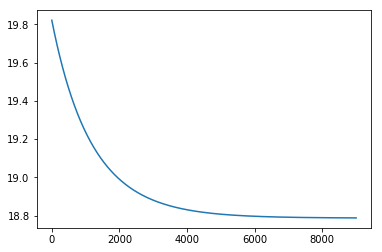

In [185]:
LR = Linear_Regression()
loss = LR.fit(X_train, y_train[:,None], 
      learning_rate=best_param['learning_rate'], 
      epochs=9000, tol=None, 
      regularizer=best_param['regularizer'],
      lambd=best_param['lambd'], lr_decay=0.985)
plt.plot(loss)

In [186]:
LR_pred = LR.predict(X_test)
print("MSE: ", mse(LR_pred.ravel(), y_test.ravel()))
print("\nr2: ", r2_score(y_test.ravel(), LR_pred.ravel()))

MSE:  30.43435383409088

r2:  -49.25280302842664


In [187]:
LR_sklearn = linear_model.SGDRegressor(loss='squared_loss',
                                       penalty=None,tol=None, 
                                       alpha=0.1, max_iter=3000,
                                       eta0=0.00001)
LR_sklearn.fit(X_train,  y_train[:,None])
sklearn_pred = LR_sklearn.predict(X_test)
print("MSE: ", mse(sklearn_pred.ravel(), y_test.ravel()))
print("\nr2: ", r2_score(y_test.ravel(), sklearn_pred.ravel()))

MSE:  3.93337010296169

r2:  -5.494728756180293


### 14. Use best model to plot the learning curve.

(20,)


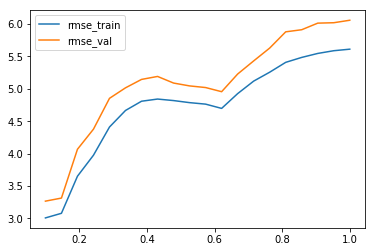

In [188]:
train_size=np.linspace(0.1, 1.0, 20)

rmse_train, rmse_val = learning_curve(Linear_Regression(), X_train, y_train, 10, 
                      train_size=train_size,
                      learning_rate=best_param['learning_rate'], 
                      epochs=9000, tol=None, 
                      regularizer=best_param['regularizer'], 
                      lambd=best_param['lambd'])

print(rmse_train.shape)
plt.plot(train_size,rmse_train, label='rmse_train')
plt.plot(train_size,rmse_val, label='rmse_val')
plt.legend()
plt.show()

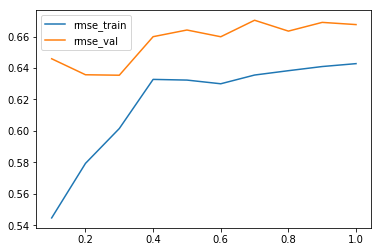

In [189]:
#sklearn sanity check
rmse_train, rmse_val = learning_curve(linear_model.LinearRegression(), 
                            X_train, y_train, 5, 
                      learning_rate=best_param['learning_rate'], 
                      epochs=2000, tol=None, 
                      regularizer=best_param['regularizer'], 
                      lambd=best_param['lambd'])
plt.plot(np.linspace(0.1, 1.0, 10),rmse_train, label='rmse_train')
plt.plot(np.linspace(0.1, 1.0, 10),rmse_val, label='rmse_val')
plt.legend()
plt.show()

### 15. Determin the best hyper-param for training data matrix with poly deg 3. and plot learning curve

In [190]:
X_train_poly = polynomialFeatures(X_train, 3)
X_test_poly = polynomialFeatures(X_test, 3)


print('X_train_poly', X_train_poly.shape)
print('X_test_poly', X_test_poly.shape)

X_train_poly (1279, 220)
X_test_poly (320, 220)


In [191]:
lambds = [0.01]
learning_rates  = [0.01, 0.001, 0.0001, 0.00076]
regularizers = ['l2']
batch_sizes = [None]


LR_poly_basket = []
best_poly_param = None
best_poly_score = 0.0
book_poly_keeping = {}



print("Sanity check: on X_train_poly_shape", X_train_poly.shape)
for lr in learning_rates:
    for reg in regularizers:
        for lambd in lambds:
            for batch_size in batch_sizes:
                book_poly_keeping = kFold(folds=5, data=X_train_poly, 
                            labels=y_train, 
                            model=Linear_Regression(), error_function=mse,
                            model_args={
                                'learning_rate':lr,
                                'regularizer':reg,
                                'lambd': lambd,
                                'batch_size' : batch_size
                            })

                LR_poly_basket.append(
                    {
                        'learning_rate': lr,
                        'regularizer': reg,
                        'lambd': lambd,
                        'batch_size' : batch_size,
                        'scores':book_poly_keeping['avg_scores']
                    }
                )
                if book_poly_keeping['avg_scores'] > best_poly_score:
                    best_poly_score = book_poly_keeping['avg_scores']
                    best_poly_param = {'learning_rate':lr, 
                                  'regularizer':reg,
                                  'lambd': lambd}

Sanity check: on X_train_poly_shape (1279, 220)


In [192]:
LR_poly_basket.sort(key = lambda x:float(x['scores']), reverse =False)
try: del df, table_poly
except: pass

#Create table for the report 
table_poly = {
    'learning_rate': [],
    'regularizer': [],
    'lambd': [],
    'scores': []
}

for i in range(len(LR_poly_basket)):
    for field in list(table_poly.keys()):
        table_poly[field].append(LR_poly_basket[i][field])
        
df = pd.DataFrame(table_poly)
print("Sorted table based on performance measure")
df

Sorted table based on performance measure


,lambd,learning_rate,regularizer,scores
0,0.01,0.00076,l2,33.118339
1,0.01,0.00100,l2,41.300611
2,0.01,0.01000,l2,42.040918
3,0.01,0.00010,l2,52.370085


In [193]:
#change for reusaability
best_poly_param = {'learning_rate': 0.00076, 
                   'regularizer': 'l2', 
                   'lambd': 0.01}

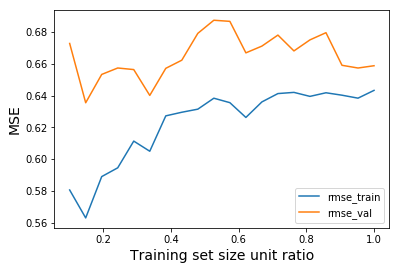

In [197]:
train_size=np.linspace(0.1, 1.0, 20)

rmse_train, rmse_val = learning_curve(Linear_Regression(), X_train_poly,
                      y_train, 4, 
                      train_size=train_size,
                      learning_rate=best_poly_param['learning_rate'], 
                      epochs=4000, tol=None, 
                      regularizer=best_poly_param['regularizer'], 
                      lambd=best_poly_param['lambd'])

plt.plot(train_size,rmse_train, label='rmse_train')
plt.plot(train_size,rmse_val, label='rmse_val')
plt.xlabel("Training set size unit ratio", fontsize=14) 
plt.ylabel("MSE", fontsize=14) 
plt.legend()
plt.show()

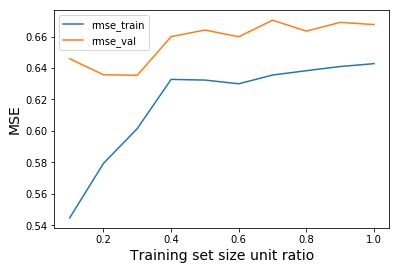

In [199]:
#sklearn sanity check
rmse_train, rmse_val = learning_curve(linear_model.LinearRegression(), 
                            X_train, y_train, 5, 
                      learning_rate=best_param['learning_rate'], 
                      epochs=2000, tol=None, 
                      regularizer=best_param['regularizer'], 
                      lambd=best_param['lambd'])
plt.plot(np.linspace(0.1, 1.0, 10),rmse_train, label='rmse_train')
plt.plot(np.linspace(0.1, 1.0, 10),rmse_val, label='rmse_val')
plt.xlabel("Training set size unit ratio", fontsize=14) 
plt.ylabel("MSE", fontsize=14) 
plt.legend()
plt.show()

### Determine the best hyper-param for training data matrix with poly deg 3. and plot learning curve

In [201]:
X_train_poly = polynomialFeatures(X_train, 3)
X_test_poly = polynomialFeatures(X_test, 3)

#standadize the data
scaler = StandardScaler().fit(X_train_poly)
X_train_poly = scaler.transform(X_train_poly)

scaler = StandardScaler().fit(X_test_poly)
X_test_poly = scaler.transform(X_test_poly)

print('X_train_poly', X_train_poly.shape)
print('X_test_poly', X_test_poly.shape)

X_train_poly (1279, 220)
X_test_poly (320, 220)


In [202]:
lambds = [0.01]
learning_rates  = [0.01, 0.001, 0.0001, 0.00076]
regularizers = ['l2']
batch_sizes = [None]


LR_poly_basket = []
best_poly_param = None
best_poly_score = 0.0
book_poly_keeping = {}



print("Sanity check: on X_train_poly_shape", X_train_poly.shape)
for lr in learning_rates:
    for reg in regularizers:
        for lambd in lambds:
            for batch_size in batch_sizes:
                book_poly_keeping = kFold(folds=5, data=X_train_poly, 
                            labels=y_train, 
                            model=Linear_Regression(), error_function=mse,
                            model_args={
                                'learning_rate':lr,
                                'regularizer':reg,
                                'lambd': lambd,
                                'batch_size' : batch_size
                            })

                LR_poly_basket.append(
                    {
                        'learning_rate': lr,
                        'regularizer': reg,
                        'lambd': lambd,
                        'batch_size' : batch_size,
                        'scores':book_poly_keeping['avg_scores']
                    }
                )
                if book_poly_keeping['avg_scores'] > best_poly_score:
                    best_poly_score = book_poly_keeping['avg_scores']
                    best_poly_param = {'learning_rate':lr, 
                                  'regularizer':reg,
                                  'lambd': lambd}

Sanity check: on X_train_poly_shape (1279, 220)


In [203]:
LR_poly_basket.sort(key = lambda x:float(x['scores']), reverse =False)
try: del df, table_poly
except: pass

#Create table for the report 
table_poly = {
    'learning_rate': [],
    'regularizer': [],
    'lambd': [],
    'scores': []
}

for i in range(len(LR_poly_basket)):
    for field in list(table_poly.keys()):
        table_poly[field].append(LR_poly_basket[i][field])
        
df = pd.DataFrame(table_poly)
print("Sorted table based on performance measure")
df

Sorted table based on performance measure


,lambd,learning_rate,regularizer,scores
0,0.01,0.00010,l2,35.047669
1,0.01,0.00076,l2,36.117150
2,0.01,0.00100,l2,36.932247
3,0.01,0.01000,l2,41.389351


In [204]:
#change for reusaability
best_poly_param = {'learning_rate': 0.0001, 
                   'regularizer': 'l2', 
                   'lambd': 0.01}

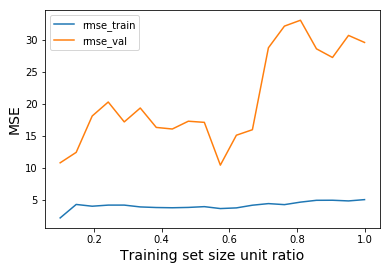

In [206]:
train_size=np.linspace(0.1, 1.0, 20)

rmse_train, rmse_val = learning_curve(Linear_Regression(), X_train_poly,
                      y_train, 4, 
                      train_size=train_size,
                      learning_rate=best_poly_param['learning_rate'], 
                      epochs=4000, tol=None, 
                      regularizer=best_poly_param['regularizer'], 
                      lambd=best_poly_param['lambd'])

plt.plot(train_size,rmse_train, label='rmse_train')
plt.plot(train_size,rmse_val, label='rmse_val')
plt.xlabel("Training set size unit ratio", fontsize=14) 
plt.ylabel("MSE", fontsize=14) 
plt.legend()
plt.show()

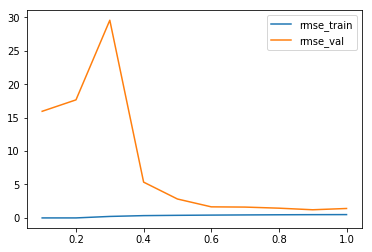

In [207]:
#sklearn sanity check
rmse_train, rmse_val = learning_curve(linear_model.LinearRegression(), 
                                      X_train_poly, y_train, 5, 
                      learning_rate=best_param['learning_rate'], 
                      epochs=2000, tol=None, 
                      regularizer=best_param['regularizer'], 
                      lambd=best_param['lambd'])
plt.plot(np.linspace(0.1, 1.0, 10),rmse_train, label='rmse_train')
plt.plot(np.linspace(0.1, 1.0, 10),rmse_val, label='rmse_val')
plt.legend()
plt.show()

### 16. Plot polynomial model complexity 1,2,3,4, and 5

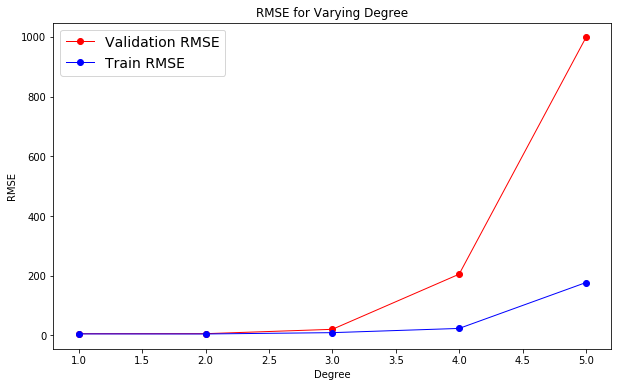

In [211]:
_, _ = plot_polynomial_model_complexity(Linear_Regression(), 
                                        X_train, y_train, 5, 5, 
                                 learning_rate=0.0025, epochs=4000, 
                                        tol=None, regularizer='l2', lambd=0.01)

### 17. Implement SGD. Using CV determine the best model then evaluate model on test set

In [219]:
lambds = [0.001, 0.0001]
learning_rates  = [0.01, 0.001, 0.0001]
regularizers = ['l2']
batch_sizes = [128, 500]


LR_sgd_basket = []
best_sgd_param = None
best_sgd_score = 0.0
book_sgd_keeping = {}

for lr in learning_rates:
    for reg in regularizers:
        for lambd in lambds:
            for batch_size in batch_sizes:
                book_sgd_keeping = kFold(folds=5, data=X_train, labels=y_train, 
                        model=Linear_Regression(), error_function=mse,
                        model_args={
                            'learning_rate':lr,
                            'regularizer':reg,
                            'lambd': lambd,
                            'batch_size' : batch_size
                        })

                LR_sgd_basket.append(
                    {
                        'learning_rate': lr,
                        'regularizer': reg,
                        'lambd': lambd,
                        'batch_size' : batch_size,
                        'scores':book_sgd_keeping['avg_scores']
                    }
                )
                if book_sgd_keeping['avg_scores'] > best_sgd_score:
                    best_sgd_score = book_sgd_keeping['avg_scores']
                    best_sgd_param = {'learning_rate':lr, 
                                  'regularizer':reg,
                                  'lambd': lambd,
                                  'batch_size' : batch_size}

In [220]:
LR_sgd_basket.sort(key = lambda x:float(x['scores']), reverse =False)
try:
    del df, table
except:
    pass

#Create table for the report 
table_sgd = {
    'learning_rate': [],
    'regularizer': [],
    'lambd': [],
    'batch_size': [],
    'scores': []
}

for i in range(len(LR_sgd_basket)):
    for field in list(table_sgd.keys()):
        table_sgd[field].append(LR_sgd_basket[i][field])
        
df = pd.DataFrame(table_sgd)
print("Sorted table based on performance measure")
df

Sorted table based on performance measure


,batch_size,lambd,learning_rate,regularizer,scores
0,128,0.0010,0.0100,l2,34.340642
1,128,0.0001,0.0010,l2,34.345491
2,500,0.0001,0.0010,l2,37.140953
3,128,0.0001,0.0100,l2,37.506099
4,500,0.0001,0.0100,l2,39.686504
5,500,0.0010,0.0100,l2,40.851618
6,500,0.0010,0.0010,l2,44.861457
7,128,0.0001,0.0001,l2,45.126610
8,128,0.0010,0.0010,l2,45.257852
9,500,0.0001,0.0001,l2,45.418193


In [238]:
#change for reusaability
best_sgd_score = {'learning_rate': 0.0100, 
                   'regularizer': 'l2', 
                   'lambd': 0.0010,
                   'batch_size' : 128}

In [239]:
LR = Linear_Regression()
loss = LR.fit(X_train, y_train[:,None], 
      learning_rate=best_sgd_score['learning_rate'], 
      epochs=8000, tol=None, 
      regularizer=best_sgd_score['regularizer'],
      lambd=best_sgd_score['lambd'], 
      batch_size=best_sgd_score['batch_size'], lr_decay=0.99)

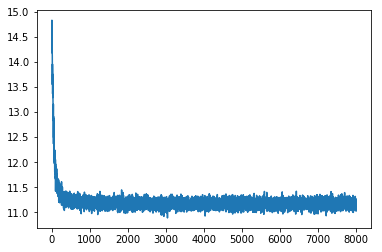

In [240]:
plt.plot(loss)

In [233]:
LR_pred = LR.predict(X_test)
print("MSE: ", mse(LR_pred.ravel(), y_test.ravel()))

MSE:  37.29133961046101
